# Задание
1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
3. Решите задачу набора данных лекции 7.

# Решение

1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.

Training RNN...
Epoch [1/20], Loss: 0.1492
Epoch [2/20], Loss: 0.0304
Epoch [3/20], Loss: 0.0122
Epoch [4/20], Loss: 0.0209
Epoch [5/20], Loss: 0.0038
Epoch [6/20], Loss: 0.0167
Epoch [7/20], Loss: 0.0143
Epoch [8/20], Loss: 0.0046
Epoch [9/20], Loss: 0.0142
Epoch [10/20], Loss: 0.0156
Epoch [11/20], Loss: 0.0183
Epoch [12/20], Loss: 0.0100
Epoch [13/20], Loss: 0.0118
Epoch [14/20], Loss: 0.0087
Epoch [15/20], Loss: 0.0100
Epoch [16/20], Loss: 0.0074
Epoch [17/20], Loss: 0.0119
Epoch [18/20], Loss: 0.0176
Epoch [19/20], Loss: 0.0155
Epoch [20/20], Loss: 0.0085

Training LSTM...
Epoch [1/20], Loss: 0.3264
Epoch [2/20], Loss: 0.0899
Epoch [3/20], Loss: 0.0152
Epoch [4/20], Loss: 0.0054
Epoch [5/20], Loss: 0.0176
Epoch [6/20], Loss: 0.0112
Epoch [7/20], Loss: 0.0063
Epoch [8/20], Loss: 0.0073
Epoch [9/20], Loss: 0.0081
Epoch [10/20], Loss: 0.0082
Epoch [11/20], Loss: 0.0161
Epoch [12/20], Loss: 0.0067
Epoch [13/20], Loss: 0.0154
Epoch [14/20], Loss: 0.0167
Epoch [15/20], Loss: 0.0188
Epoc

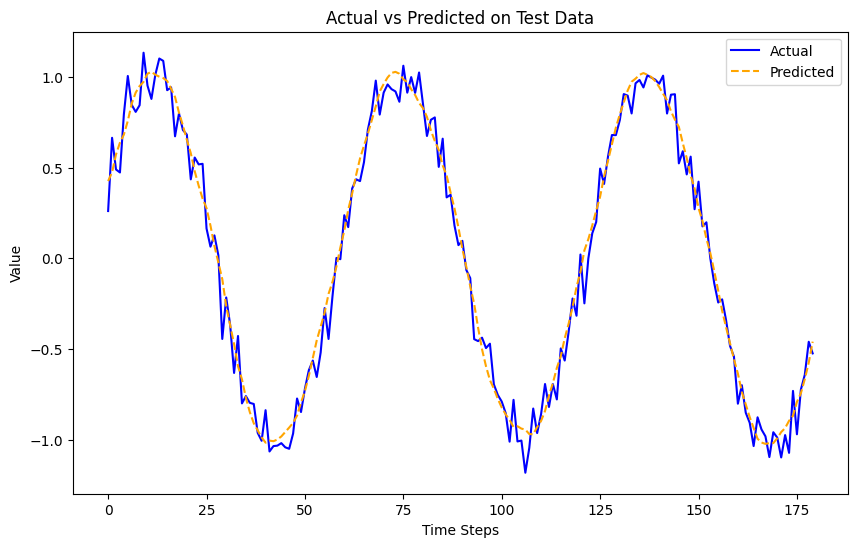

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Генерация набора данных временных последовательностей
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Создаем синусоидальный набор данных
seq_length = 20
n_samples = 1000
x = np.linspace(0, 100, n_samples)
data = np.sin(x) + 0.1 * np.random.normal(size=len(x))  # Добавляем шум для усложнения задачи

# Разделение на тренировочный и тестовый наборы данных
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Определение модели RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Инициализация скрытого состояния
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Используем только последний выход
        return out

# Модифицированная модель с LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # Инициализация скрытого состояния
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # Инициализация состояния ячейки
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Используем только последний выход
        return out

input_size = 1
hidden_size = 50
output_size = 1

def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, seq_length, input_size)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training RNN...")
rnn_model = RNN(input_size, hidden_size, output_size)
train_model(rnn_model, train_dataloader, epochs=20)

print("\nTraining LSTM...")
lstm_model = LSTM(input_size, hidden_size, output_size)
train_model(lstm_model, train_dataloader, epochs=20)

# Проверка модели на тестовом наборе данных
model = lstm_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

plt.figure(figsize=(10, 6))
plt.plot(actual, label="Actual", linestyle='-', color='blue')
plt.plot(predictions, label="Predicted", linestyle='--', color='orange')
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("Actual vs Predicted on Test Data")
plt.show()

# 3. Задание из 7 лекции
1. Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)

In [12]:
import pandas as pd
import numpy as np

N = 2

df = pd.read_csv('ETTh1.csv')
dfs = np.array_split(df, N)

C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


2. Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

train = dfs[0].OT
test = dfs[1].OT

model = ARIMA(train, order=(3,0,0))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 92.33428017397732


3. Исследовать качество работы модели в зависимости от параметров (для групп 1-2).

In [14]:
# Параметры для исследования (p, d, q)
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                predictions = model_fit.forecast(steps=len(test))

                mse = mean_squared_error(test, predictions)
                
                print(f'Parameters (p={p}, d={d}, q={q}): mse = {mse}')
                results.append((p, d, q, mse))

            except Exception as e:
                print(f"Error with parameters (p={p}, d={d}, q={q}): {e}")

results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'MSE'])
best_params = results_df.loc[results_df['MSE'].idxmin()]

Parameters (p=0, d=0, q=0): mse = 92.49351338515292
Parameters (p=0, d=0, q=1): mse = 92.5094180906286
Parameters (p=0, d=0, q=2): mse = 92.49477947915335


C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters (p=0, d=0, q=3): mse = 92.50340023485523
Parameters (p=0, d=1, q=0): mse = 154.28607692860015
Parameters (p=0, d=1, q=1): mse = 154.19163728431104
Parameters (p=0, d=1, q=2): mse = 154.0868127944236
Parameters (p=0, d=1, q=3): mse = 153.47002785867272
Parameters (p=1, d=0, q=0): mse = 92.33016537373585
Parameters (p=1, d=0, q=1): mse = 92.32336549214587
Parameters (p=1, d=0, q=2): mse = 92.3313253271354
Parameters (p=1, d=0, q=3): mse = 92.34875887201707
Parameters (p=1, d=1, q=0): mse = 154.1877804385313
Parameters (p=1, d=1, q=1): mse = 143.23457094626087
Parameters (p=1, d=1, q=2): mse = 153.88560942966149
Parameters (p=1, d=1, q=3): mse = 153.45226043138425
Parameters (p=2, d=0, q=0): mse = 92.32527256372875


C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters (p=2, d=0, q=1): mse = 92.40757433371697
Parameters (p=2, d=0, q=2): mse = 107.25808663504012
Parameters (p=2, d=0, q=3): mse = 95.15753472744868
Parameters (p=2, d=1, q=0): mse = 154.11260035969462


C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters (p=2, d=1, q=1): mse = 153.916315649946
Parameters (p=2, d=1, q=2): mse = 153.1470447481544
Parameters (p=2, d=1, q=3): mse = 153.21252369854403
Parameters (p=3, d=0, q=0): mse = 92.33428017397732
Parameters (p=3, d=0, q=1): mse = 92.37051449365647
Parameters (p=3, d=0, q=2): mse = 92.36245620145779
Parameters (p=3, d=0, q=3): mse = 95.29082881065894
Parameters (p=3, d=1, q=0): mse = 153.35153872188815
Parameters (p=3, d=1, q=1): mse = 153.39403841352745
Parameters (p=3, d=1, q=2): mse = 153.2105702189035


C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\derta\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Parameters (p=3, d=1, q=3): mse = 153.06344526871456


In [15]:
print("Best Parameters (p, d, q):\n", best_params[['p', 'd', 'q']])
print("Best MSE:", best_params['MSE'])

Best Parameters (p, d, q):
 p    1.0
d    0.0
q    1.0
Name: 9, dtype: float64
Best MSE: 92.32336549214587


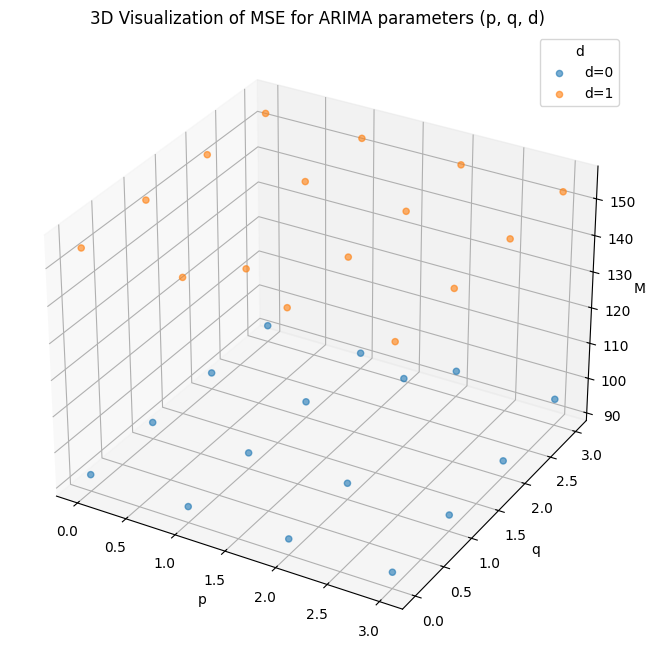

In [16]:
import matplotlib.pyplot as plt

results_df = results_df.groupby(["p", "d", "q"], as_index=False)["MSE"].mean()

d_values = results_df["d"].unique()

# Настройка 3D графика
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for d in d_values:
    subset_df = results_df[results_df["d"] == d]
    p_values = subset_df["p"]
    q_values = subset_df["q"]
    mse_values = subset_df["MSE"]

    ax.scatter(p_values, q_values, mse_values, label=f'd={d}', alpha=0.6)

ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('MSE')
ax.legend(title="d")
ax.set_title("3D Visualization of MSE for ARIMA parameters (p, q, d)")
plt.show()

4. Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу "экспоненциальное среднее".

In [17]:
alpha = 0.5  # Коэффициент сглаживания для экспоненциального среднего

model = ARIMA(train, order=(1, 0, 0)).fit()

predictions = []
current_prediction = model.forecast(steps=1).iloc[0]  # Первое предсказание

for true_value in test:
    predictions.append(current_prediction)
    current_prediction = alpha * true_value + (1 - alpha) * current_prediction

mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error (Iterative with Exponential Smoothing): {mse}')

Mean Squared Error (Iterative with Exponential Smoothing): 0.7109406694751832
